# Installations and Imports

In [ ]:
%pip install qiskit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
%pip install qiskit-aer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.5 MB/s eta 0:00:00


In [ ]:
%pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import qiskit_aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit.visualization.state_visualization import plot_bloch_multivector
import time
import random
from random import choice
from qiskit.quantum_info.states.random import random_statevector
from qiskit.quantum_info.states.measures import DensityMatrix
import qiskit.quantum_info as qi
from qiskit.quantum_info.operators.random import random_unitary
from timeit import default_timer as timer

In [ ]:
#Defines an array of a few gates required for a Pauli matrix
class GameGates():
  X_Gate = np.array([[0,1],[1,0]])
  Z_Gate = np.array([[1,0],[0,-1]])
  Y_Gate = np.array([[0,-1j],[1j,0]])
  I_Gate = np.array([[1,0],[0,1]])
  H_Gate = (1/np.power(2,1/2))*np.array([[1,1],[1,-1]])

  def __init__(self, I_Gate, X_Gate, Y_Gate,Z_Gate):
    self.I_Gate = I_Gate
    self.X_Gate = X_Gate
    self.Y_Gate = Y_Gate
    self.Z_Gate = Z_Gate

In [ ]:
#Initializes a random quantum state
def StatePreperation():
  vec = random_statevector(2)
  qc = QuantumCircuit(1)
  qc.initialize(vec.data,0)
  return qc, vec

In [ ]:
#Measures the state in preparation for creating the density matrix
def PauliCircuit(qc):
  #Measure in Z basis
  Zqc= QuantumCircuit(1,1)
  Zqc.compose(qc, inplace=True)
  Zqc.barrier()

  Zqc.measure(0,0)


  #Measure in X basis
  Xqc= QuantumCircuit(1,1)
  Xqc.compose(qc, inplace=True)
  Xqc.barrier()

  Xqc.h(0)
  Xqc.measure(0,0)


  #Measure in Y basis
  Yqc= QuantumCircuit(1,1)
  Yqc.compose(qc, inplace=True)
  Yqc.barrier()

  Yqc.sdg(0)
  Yqc.h(0)
  Yqc.measure(0,0)

  backend=qiskit_aer.Aer.get_backend('qasm_simulator')

  #Z basis results
  newZ = transpile(Zqc, backend)
  jobZ = backend.run(newZ)
  dataZ = jobZ.result().get_counts()


  #X basis results
  newX = transpile(Xqc, backend)
  jobX = backend.run(newX)
  dataX = jobX.result().get_counts()

  #Y basis results
  newY = transpile(Yqc, backend)
  jobY = backend.run(newY)
  dataY = jobY.result().get_counts()


  return dataZ, dataX, dataY, Zqc, Xqc, Yqc

In [ ]:
#Calculates expectation values from the Pauli Circuit measurement data
def expValues(PauliCircuit):
  dataZ = PauliCircuit[0]
  dataX = PauliCircuit[1]
  dataY = PauliCircuit[2]

  expVal_Z= (dataZ['0']-dataZ['1'])/(dataZ['0']+dataZ['1'])
  expVal_X= (dataX['0']-dataX['1'])/(dataX['0']+dataX['1'])
  expVal_Y= (dataY['0']-dataY['1'])/(dataY['0']+dataY['1'])

  return expVal_Z, expVal_X, expVal_Y

In [ ]:
#Creates a density matrix from the Pauli matrix obtained from the Pauli Circuit
def PauliDensityMatrix(expValues):
  p = (1/2)*(GameGates.I_Gate + (GameGates.X_Gate*expValues[1])+ (GameGates.Y_Gate*expValues[2])+(GameGates.Z_Gate * expValues[0])) #creates a pauli matrix
  d = DensityMatrix(p) #converts matrix into a density matrix
  if (d.probabilities()[0] > d.probabilities()[1]) and (np.random.randint(2) == 0): #noticed that there tended to be a higher chance of high probability for measuring |0>. "Rigged" the probabilities so that there is a 50% chance they are swapped if probability of |0> is greater than |1>.
    d = d.evolve(GameGates.X_Gate)
  return d

In [ ]:
#Takes in players input and applies the corresponding gate to the quantum state
def gameInput(input, PauliDensityMatrix):

  U1 = random_unitary(2)
  U2 = random_unitary(2)
  gateDict = {'R':GameGates.H_Gate, 'B':GameGates.X_Gate, 'G':U1, 'P':U2}
  d = PauliDensityMatrix

  de = d.evolve(gateDict[input])
  return de

In [ ]:
#Initializes a single qubit "bomb"
def initializeBomb():
  qc = StatePreperation()[0]
  Pauli_Circuit = PauliCircuit(qc)
  exp_Values = expValues(Pauli_Circuit)
  d = PauliDensityMatrix(exp_Values)

  return d

In [ ]:
#Time Delay function
def wait(a):
  time.sleep(a)




import time
import sys


In [ ]:
def game():
    """
    print('> Loading imports...')
    wait(1)
    print('> Loading Bombs...')
    wait(1)
    print('> Loading Spooky Action...')
    wait(1)
    print('> Starting up Game...')
    wait(2)
    print("\nInspired by the game 'Extreme Bomb Defusing!' and 'Don't Stop Talking!'...")
    wait(1)
    print("\n\tPratham presents...")
    wait(1)
    print("\n\t\tQuantum Bomb Defusal! ")

    wait(1)
    print('')

    inputDict = {'R':'Red Wire', 'G':'Green Wire', 'B':'Blue Wire', 'P':'Purple Wire'} #Input dictionary for player reference
    """
    #Prints objective, instructions, and game mechanic info if player requests
    print("Objective: To defuse a bomb before the timer goes out.")
    print("Instructions:\n1. This is a very special \"quantum\" bomb where you must defuse the bomb by detonating the bomb. The bomb consists of four wires (Red, Green, Blue, Purple) which you can cut in any order you like and you do not need to cut all of them to win.")
    print("2. There is a limited number of wires (which will be displayed by the first letter of the wire color and the number proceeding the colon). Also be mindful of the timer!")
    print("3. When the timer reaches zero during your turn, you are allowed to finish your turn before the bomb is detonated (keep in mind you also have as much time as you want to finish this turn)")
    print("4. If you attempt to cut a wire when there are none left, then the bomb will detonate immediately.")
    print("4. Lastly, have fun and don't blow up!\n")

    inp = input("If you are a new player or want to look at the game mechanics again, input \'Y\'. If not, enter anything you want to continue: ")
    if inp.upper().strip() == 'Y':
      print("GAME MECHANICS\n1. The bomb is randomly created at the start of each game along with how many wires it consists of.")
      print("2. Difficulty changes the amount of wires present, number of available measurements, and amount of time.")
      print("3. You are given a measurement device which tells you the success and failure probabilities at any given time. Note that you can only use this device after the first wire has been cut.")
      print("4. Detonating the bomb will cause the bomb to attempt to explode. If the probability of explosion is high, then the bomb is most likely to explode but also may not explode. Vice versa for low explosion probability.")
      print("5. Each color wire has a unique effect on the bomb in each game. It is your job to analyze patterns and use them to your adventage to defuse the bomb.")
      print("6. Here is a list of all the wires: ",inputDict)
      print("7. The effects of some wires change each game so be sure to cut wires and measuree wisely.\n")

    #Asks difficulty
    print('Difficulties:')
    print('0. Tutorial (10 Minutes, 100 Measurements, 100 Wires Each)')
    print('1. Easy (5 Minutes, 10 Measurements, 5-11 Wires Each)')
    print('2. Medium (3 Minutes, 8 Measurements, 4-8 Wires Each)')
    print('3. Hard (2 Minutes, 3 Measurements, 3-7 Wires Each)')
    wait(1)
    Difficulty = int(input('\nWhat is your Difficulty? (Enter corresponding number)\n>'))

    MaximumMeasures = 0
    #Set Game difficulty
    if Difficulty == 0:
      MaximumMeasures = 100
      timeTotal = 1000
      wiresDict = {'R':100, 'G':100, 'B':100, 'P':100}

    if Difficulty == 1:
      MaximumMeasures = 10
      timeTotal = 300
      wiresDict = {'R':np.random.randint(5,11), 'G':np.random.randint(5,11), 'B':np.random.randint(5,11), 'P':np.random.randint(5,11)}

    if Difficulty == 2:
      MaximumMeasures = 8
      timeTotal = 180
      wiresDict = {'R':np.random.randint(4,8), 'G':np.random.randint(4,8), 'B':np.random.randint(4,8), 'P':np.random.randint(4,8)}

    if Difficulty == 3:
      MaximumMeasures = 3
      timeTotal = 120
      wiresDict = {'R':np.random.randint(3,7), 'G':np.random.randint(3,7), 'B':np.random.randint(3,7), 'P':np.random.randint(3,7)}



    #Initializes bomb and creates a copy of the bomb for the player to defuse
    bomb = initializeBomb()
    bomb1 = bomb

    start = timer() #Stores the programs running time at this instant

    timeRemaining = timeTotal

    #Main game portion
    while timeRemaining > 0:
      start = timer()
      print("Measurements Remaining: ",MaximumMeasures,"\nWires Remaining: ", wiresDict,"\n")
      inp = input("Choose which wire to cut: ")

      if wiresDict[inp.upper().strip()] > 0:
        bomb1 = gameInput(inp.upper(),bomb1) #Changes the state of bomb1 according to which wire the player
        wiresDict[inp.upper().strip()] -= 1
      else:
        state = bomb1.measure()[0]
        if state == '0':
          result = "You did it!"
        else:
          result = "ggs R.I.P."
        break

      if MaximumMeasures > 0:
        inp = input("Would you like to use your measurement device? (Y/N): ")
        if inp.upper().strip() == 'Y':
          MaximumMeasures -= 1
          success = bomb1.probabilities()[0]*100 #Prints probabilities of success/failure if player requests
          explosion = bomb1.probabilities()[1]*100
          print("Chance of success: ",success,"%\nChance of explosion: ", explosion,"%")
        elif (inp.upper().strip() != 'N'):
          raise Exception("Invalid Input. Please enter Y or N next time.")


      inp1 = input("Would you like to detonate? (Y/N): ")
      if inp1.upper().strip() == 'Y':
        state = bomb1.measure()[0]
        if state == '0':
          result = "You did it!"
        else:
          result = "ggs R.I.P."
          end = timer() #Stores the programs running time at this instant
          timeRemaining -= int(end - start)
        break
      elif (inp1.upper().strip() != 'N'):
        raise Exception("Invalid Input. Please enter Y or N next time.")

      end = timer() #Stores the programs running time at this instant
      timeRemaining -= int(end - start)
      if timeRemaining > 0: #timeRemaining will not be printed in negative seconds
        print("Time Remaining: ",timeRemaining,"s")
      else:
        print("Time Remaining: 0 s")

    if inp1.upper().strip() != 'Y':
      state = bomb1.measure()[0]
      if state == '0':
        result = "You did it!"
      else:
        result = "ggs R.I.P."

    print(result)
    print("Well played")

    print("\nStats:\nInitial bomb explosion probability: ",bomb.probabilities()[1]*100,"%\nFinal bomb explosion probability: ",bomb1.probabilities()[1]*100,"%\nTime took: ",int(timeTotal-timeRemaining)," seconds")


# Quantum Bomb Defusal

In [ ]:
game()

Objective: To defuse a bomb before the timer goes out.
Instructions:
1. This is a very special "quantum" bomb where you must defuse the bomb by detonating the bomb.The bomb consists of four wires (Red, Green, Blue, Purple) which you can cut in any order you like and you do not need to cut all of them to win.
2. There is a limited number of wires (which will be displayed by the first letter of the wire color and the number proceeding the colon). Also be mindful of the timer!
3. When the timer reaches zero during your turn, you are allowed to finish your turn before the bomb is detonated (keep in mind you also have as much time as you want to finish this turn)
4. If you attempt to cut a wire when there are none left, then the bomb will detonate immediately.
4. Lastly, have fun and don't blow up!

If you are a new player or want to look at the game mechanics again, input 'Y'. If not, enter anything you want to continue: n
Difficulties:
0. Tutorial (10 Minutes, 100 Measurements, 100 Wires 

# Behind the Scenes


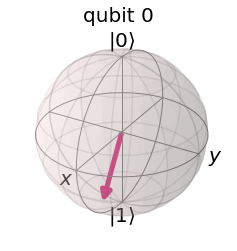

In [ ]:
d = initializeBomb()
plot_bloch_multivector(d.data)

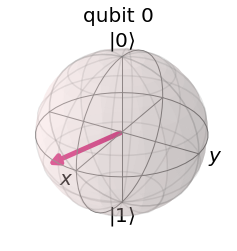

In [ ]:
d1 = gameInput('G',d)
plot_bloch_multivector(d1.data)

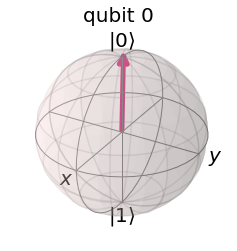

In [ ]:
d1 = gameInput('R',d)
plot_bloch_multivector(d1.data)

In [ ]:
print(d1.probabilities())
print(d1.measure()[0])

[0.92675781 0.07324219]
0
